In [1]:
import torch
import torch.nn
import torch.nn.functional as F

In [2]:
from model.encoder import Encoder
from model.decoder import Decoder

In [19]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [45]:
import os
import matplotlib.pyplot as plt
from dataset import get_dataset, collate_fn, vocab_size, int2char, char2int, SOS_CHAR
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import ScaleImageByHeight, AverageMeter, accuracy

In [21]:
config = {
    'batch_size': 32,
    'hidden_size': 256,
    'attn_size': 256,
    'max_length': 10,
    'n_epochs_decrease_lr': 15,
    'start_learning_rate': 1e-5,  # NOTE: paper start with 1e-8
    'end_learning_rate': 1e-11,
    'depth': 4,
    'n_blocks': 3,
    'growth_rate': 96,
}

In [22]:
MAX_LENGTH = config['max_length']
CKPT_DIR = './ckpt'

In [23]:
info = torch.load(os.path.join(CKPT_DIR, 'BEST_weights.pt'), map_location='cpu')

In [24]:
image_transform = transforms.Compose([
    transforms.Grayscale(3),
    ScaleImageByHeight(64),
    transforms.ToTensor(),
])

In [25]:
test_data = get_dataset('test', image_transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [26]:
encoder = Encoder(config['depth'], config['n_blocks'], config['growth_rate'])
if info['encoder_state'] is not None:
    encoder.load_state_dict(info['encoder_state'])

In [27]:
    decoder = Decoder(encoder.n_features,
                      config['hidden_size'], vocab_size, config['attn_size'])
    if info['decoder_state'] is not None:
        decoder.load_state_dict(info['decoder_state'])

In [28]:
encoder = encoder.to(device)
decoder = decoder.to(device)

In [29]:
encoder.eval()
decoder.eval();

In [58]:
test_iter = iter(test_loader)

In [71]:
imgs, targets, targets_onehot, lengths = next(test_iter)

In [72]:
imgs.size()

torch.Size([1, 3, 64, 80])

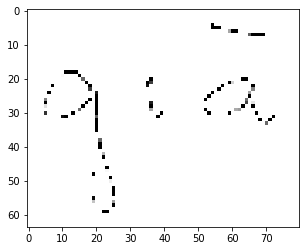

In [73]:
plt.imshow(imgs.squeeze().permute(1,2,0))

In [74]:
targets.size()

torch.Size([5, 1, 1])

In [75]:
''.join([int2char[x.item()] for x in targets.squeeze()])

'<start>già<end>'

In [76]:
start_input = torch.zeros(1, 1, vocab_size)
start_input[0,0, char2int[SOS_CHAR]] = 1
start_input

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [77]:
with torch.no_grad():
#     for i, (imgs, targets, targets_onehot, lengths) in enumerate(val_loader):
    img_features = encoder(imgs)
    outputs, weights = decoder.greedy(img_features, start_input)

In [78]:
outputs.size()

torch.Size([10, 1, 150])

In [79]:
_, index = outputs.topk(1, -1)

In [80]:
''.join([int2char[x.item()] for x in index.squeeze()])

'<start>iià<end><end><end><end><end><end>'

In [81]:
weights.size()

torch.Size([10, 1, 20])